# R notebook tutorial about hierarchical Bayesian models to Infer PL(Z) relations using Gaia parallaxes

#### Héctor E. Delgado
#### Luis M. Sarro

__This version of the tutorial was modified by Anthony Brown to remove the interface to python and to remove the inline generation of the DAGs.__

In this tutorial, we first briefly introduce the Bayesian paradigm for statistical inference and the concept of hierarchical Bayesian graphical models. We simulate some toy problems with R and illustrate how we can easily represent them and infer their parameters of interest by means of the Stan programming language and its interface Rstan for R. The second part of the tutorial is devoted to using the Bayesian hierarchical methodology to derive a set of Period-Luminosity-Metallicity relations from Gaia parallaxes and photometry in several bands. We study the stability of the solutions and the sensitivity to the prior and hyperprior choices.

# Bayesian Graphical Models

## The Bayesian paradigm 

Bayesian inference is based on Bayes' rule:

$$
p\left(\Theta\mid\mathcal{D}\right)=\frac{p\left(\mathcal{D}\mid\Theta\right)\times p\left(\Theta\right)}{p\left(\mathcal{D}\right)}\,,
$$
where $\mathcal{D}$ are the observations (data), $\Theta$ are the parameters of a model proposed to explain the data, and $p$ represent (discrete or continuous) probability distributions. Given that the probability of the data is independent of the parameters, we can drop it and rewrite the former expression as

$$
p\left(\Theta\mid\mathcal{D}\right)\propto p\left(\mathcal{D}\mid\Theta\right)\times p\left(\Theta\right)\,,
$$

where the right side represents the model, specified by the joint probability distribution $p\left(\mathcal{D},\Theta\right)$ of the data and the parameters, which factorizes into:

* The conditional probability distribution $p\left(\mathcal{D}\mid\Theta\right)$ of the data given the parameters, the so called  *likelihood*. Important: the likelihood is a probability of the data. However, the data are fixed (we have only one data set to update our prior beliefs) and hence, it is usually thought of as a function of the parameters.
* The *prior distribution* $p\left(\Theta\right)$ of the parameters, which represents our knowledge about the parameters before observing the data.

The left hand side $p\left(\Theta\mid\mathcal{D}\right)$ represents what we infer from the data using the model, which is the *joint posterior distribution* of the parameters given the data. Computing this distribution requires computing the normalizing constant $p\left(\mathcal{D}\right)$, which, in many cases, is an analytically intractable task. Furthermore, if we are only interested in a subset $\Phi$ of $\Theta =\left( \Phi ,\Lambda  \right)$, then we need to integrate (marginalize) the joint posterior distribution over the set $\Lambda$ of *nuisance parameters*, which can be challenging again. Fortunately, these two obstacles may be circumvented by sampling from the posterior distribution by means of Markov Chain Monte Carlo (MCMC) simulation techniques.   

## A toy problem, DAG models and Stan 

Let us now consider a very simple problem: To infer the mean $\mu$ of a normal (Gaussian) distribution assuming that we known its standard deviation $\sigma=0.5$. Let us first generate the data from a normal distribution centred at 3 $\mathsf{N}\left(\mu=3,\sigma=0.5\right)$: 

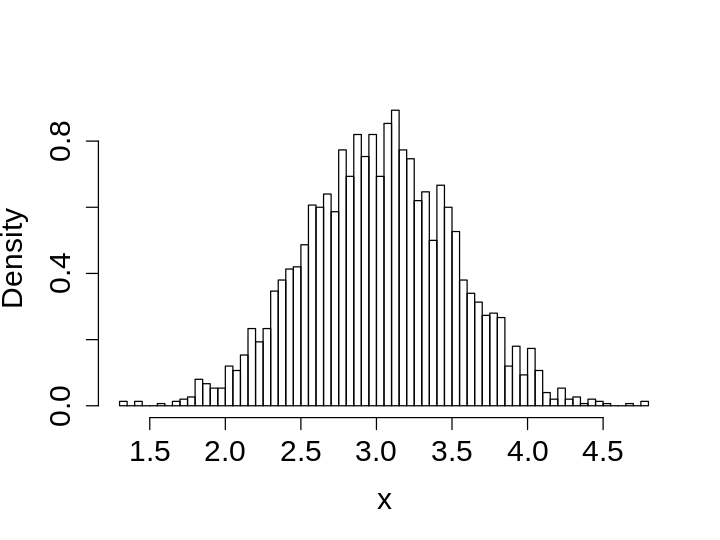

In [1]:
# Define a seed for repeatability
set.seed(12354)
# Define plot area dimensions
options(repr.plot.width=6, repr.plot.height=4.5)

N <- 3000
x.mu <- 3
x.sigma <- 0.5
x.samples <- rnorm(N, x.mu , x.sigma)
hist(x.samples,breaks=100,xlab="x",main="",freq=FALSE,cex.lab=1.5,cex.axis=1.5)

A model for this problem that assumes that the data are independent and identically distributed samples from the true distribution is:
$$
p\left(\mathcal{D},\mu\right)=\prod_{i=1}^{N}p\left(x_{\mathrm{obs},i}\mid\mu\right)\times p\left(\mu\right)
$$
where $x_{\mathrm{obs},i}\mid\mu\sim\mathsf{N}\left(\mu,\sigma=0.5\right)$, $\mu\sim\mathsf{N}\left(0,\sigma_{0}\right)$, with $\sim$ meaning *distributed as*, and $\sigma_0$ is a hyperparameter that represents our uncertainty about the true value of the mean, which we assume to be 0. 

For a better understanding of the  dependency structure between variables it is customary to represent the model using the Bayesian network formalism, which consists of drawing a DAG (directed acyclic graph) whose topology represents the factorization of the joint probability distribution $p\left(\mathcal{D},\Theta\right)$. We assign each node of the DAG to a factor distribution of $p\left(\mathcal{D},\Theta\right)$. If the factor distribution is a conditional distribution, then the node parents are the parameters of the distribution and if the factor distribution is an unconditional (marginal) distribution, the node has no parents.    

Now, to declare and draw the DAG corresponding to our toy model we use the [dot language](http://www.graphviz.org/Documentation/dotguide.pdf) and call the `grViz` function of the `DiagrammeR` package.  In this DAG we use the following notation:

* We denote data with two concentric circles
* We denote fixed parameters with squares
* We denote model parameters with single circles
* We denote conditional dependence relations with arcs
* We denote N times repetition with a rectangle

The following block shows the DAG for the above problem. It can be drawn from within R (see the unmodified tutorial), but this is not discussed here.

![](BGMexample1.png)

In this notebook we will carry out the inference process using the  [Stan modelling language](http://mc-stan.org/users/documentation/index.html) and its default sampler NUTS (No-U-Turn sampler) to declare our model and instantiate the MCMC sampler. To run Stan from R we load the interface [rstan](https://cran.r-project.org/web/packages/rstan/rstan.pdf):

In [2]:
library(rstan)
library(ggplot2)
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores()) 

Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


We define now the Stan model for our toy problem:

In [3]:
stanBGM1 <-'

  data {                     
    int<lower=0> N;            
    vector[N] obsx;           
    real<lower=0> sigma;
    real<lower=0> sigma0;
  }
  parameters {                
    real mu;
  }
  model {                    
    //prior
    mu ~ normal(0, sigma0);             
 
    //likelihood
    for (n in 1:N) {
      obsx[n] ~ normal(mu, sigma);
    }
  }
'

This block of code contains three subblocks. In the first one we define the data (obx) and the model constants, in the second we define the parameters (in this case the only parameter, $\mu$) and finally, in the third block we translate the model into machine interpretable code. 

Now, we load our data into a list, call the sampler and store the results of the fit:

In [4]:
# Load data 
dat = list(N = N, obsx=x.samples, sigma=x.sigma, sigma0=100)

# Start the MCMC chains (3) with 6000 steps from which the first 3000 will be
# assumed to serve for initial convergence (not representative of the posterior)
# and will be therefore discarded 
fit1 <- stan(model_code = stanBGM1, data = dat, chains = 3,  iter = 6000  , warmup = 3000, verbose = FALSE )

Finally, we print the results and plot the Markov chains and a histogram corresponding to the posterior samples of $\mu$:  

In [5]:
# summary
print(fit1, digits_summary=4)

Inference for Stan model: 272b639758a5696649844a752dd304ab.
3 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=9000.

           mean se_mean     sd       2.5%        25%        50%        75%
mu       3.0186  0.0002 0.0091     3.0009     3.0124     3.0186     3.0248
lp__ -1458.5687  0.0110 0.7031 -1460.5952 -1458.7360 -1458.3017 -1458.1201
          97.5% n_eff   Rhat
mu       3.0365  2865 1.0001
lp__ -1458.0706  4115 1.0005

Samples were drawn using NUTS(diag_e) at Mon Aug 13 13:33:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


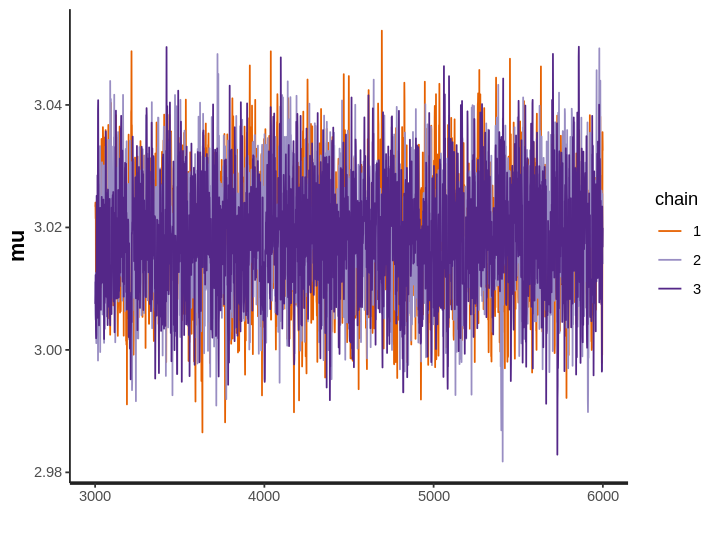

In [6]:
stan_trace(fit1,pars=c("mu"),unconstrain = FALSE)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


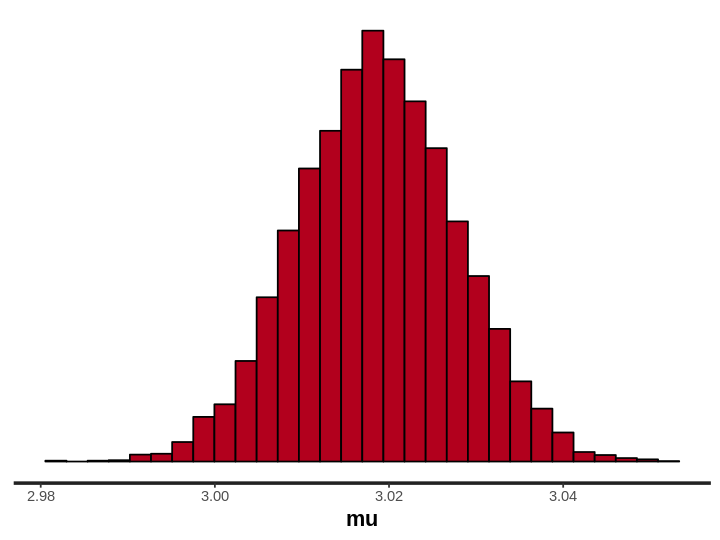

In [7]:
stan_hist(fit1,pars=c("mu"),unconstrain = FALSE)

Two important lessons to learn:

* even if this is very obvious, the posterior distribution depends on the data. In the histogram shown above you see that the mode of the posterior does not coincide with the true value of $\mu$ that generated the data. With 3000 samples, the difference is small (3.02 instead of 3), but the true value is farther than 1$\sigma_{posterior}$ from the mode. This is inevitable: the data are just one realization from the true distribution, and as such it is subject to randomness (not to mention noise in the measurements which we have obviated in this example).
* it is important to check visually and quantitatively that the chains have converged. If not, our samples will not be representative of the posterior.


## Hierarchical Modelling


A hierarchical Bayesian model (HBM) divides the conditional dependencies of a statistical problem into several levels. 

Consider the following problem: To infer the mean $\mu$ and the standard deviation $\sigma$ of a Gaussian population from $N$ samples of observed values with their corresponding uncertainties. First, let us generate some data (500 samples) from this model:


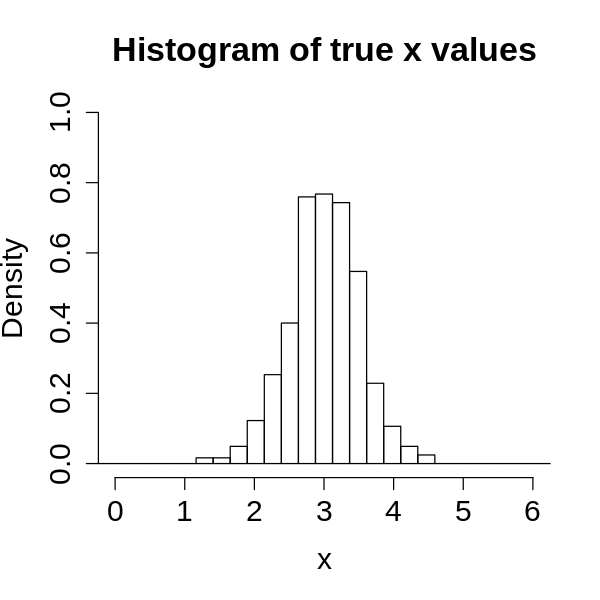

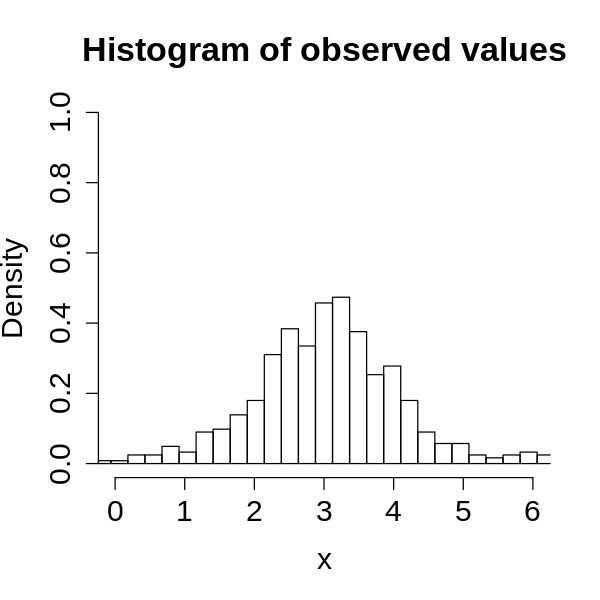

In [8]:
# Define plot area dimensions
options(repr.plot.width=5, repr.plot.height=5)

N <- 500
#Generate the samples as before
x.mu <- 3
x.sigma <- 0.5
x.samples <- rnorm(N, x.mu , x.sigma)
# Now make up some measurement uncertainties...
x.obs.errors <- rnorm(N,0,1) 
x.obs.errors <- abs(x.obs.errors)
# ...and add measurement noise to the samples 
x.obs.samples <- rnorm(N, x.samples, x.obs.errors)  
hist(x.samples,breaks=seq(-3,9,length.out=50),xlab="x",main="Histogram of true x values",
     freq=FALSE,xlim=c(0,6),ylim=c(0,1),
     cex.lab=1.5,cex.axis=1.5,cex.main=1.7)
hist(x.obs.samples,breaks=seq(-3,9,length.out=50),xlab="x",freq=FALSE,xlim=c(0,6),ylim=c(0,1),
    cex.lab=1.5,cex.axis=1.5,
    main="Histogram of observed values",cex.main=1.7)

A suitable model for this problem is:

$$
p\left(\mathcal{D},\mu\right)=p\left(\mu\right)\cdot p\left(\sigma\right)\prod_{i=1}^{N}p\left(x_{\mathrm{obs},i}\mid x_{i}\right)\cdot p\left(x_{i}\mid\mu,\sigma\right)
$$

where $x_{\mathrm{obs},i}\mid x_{i}\sim\mathsf{N}\left(x_{i},\sigma_{x_{i}}\right)$, $x_{i}\mid\mu,\sigma\sim\mathsf{N}\left(\mu,\sigma\right)$, $\mu\sim\mathsf{N}\left(\mu_{0},\sigma_{0}\right)$ and $\sigma\sim\mathsf{U}\left(0,k\right)$. That is, we distinguish between the intrinsic variability of the statistical problem (the variability at population level) and the variability of each observation due the measurement noise.

Now, we declare and draw the DAG corresponding to our HBM:

![](BGMexample2.png)

We define now the Stan model for our second problem:

In [9]:
stanBGM2 <-'

data {                     
    int<lower=0> N;            
    vector[N] obsx;           
    vector<lower=0>[N] sigmaobsx;       
  }

parameters {                
    real mu;
    real<lower=0> sigma;
    vector[N] x;   
  }

model {                    
    # hyperpriors
    mu ~ normal(0, 10); 
    sigma ~ uniform(0, 10);    

    # priors
    for (n in 1:N) {
      x[n] ~ normal(mu, sigma);
    
    # Likelihood  
      obsx[n] ~ normal(x[n], sigmaobsx[n]);
    }
  }
'

Finally, we  call the sampler and  print summary statistics of the posterior samples for the the parameters $\mu$ and $\sigma$.

In [10]:
# Create the data list object
dat = list(N = N, obsx=x.obs.samples, sigmaobsx=x.obs.errors)


fit1 <- stan(model_code = stanBGM2, chains = 1, data = dat, iter = 1, verbose = FALSE)

set.seed(12354)

fit2 = stan(fit=fit1 , data = dat,  iter = 5000  , warmup = 3000, chains = 3,verbose = FALSE)


SAMPLING FOR MODEL '176d8885b7bfd329005a01957ad15ab8' NOW (CHAIN 1).

Gradient evaluation took 8.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.81 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               0.000241 seconds (Sampling)
               0.000242 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [11]:
# summary
print(fit2, pars=c("mu","sigma"), digits_summary=4)
val1 <- summary(fit2)$summary[,"mean"]["mu"]

Inference for Stan model: 176d8885b7bfd329005a01957ad15ab8.
3 chains, each with iter=5000; warmup=3000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5% n_eff   Rhat
mu    3.0323   6e-04 0.0357 2.9623 3.0082 3.0323 3.0561 3.1033  3680 0.9998
sigma 0.5262   7e-04 0.0302 0.4692 0.5056 0.5256 0.5460 0.5862  1862 1.0000

Samples were drawn using NUTS(diag_e) at Mon Aug 13 13:35:58 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In the former example we have modelled the mean $x_i$ of each individual observation  $x_{\mathrm{obs},i}$  and the mean $\mu$ at a population level. As a consequence, we obtain shrunken (regularized) posterior estimates for each $x_i$. Let us compare the results with a non-hierarchical pooled estimation:

In [12]:
stanBGM2pooled <-'

data {                     
    int<lower=0> N;            
    vector[N] obsx;           
    vector<lower=0>[N] sigmaobsx;       
  }

parameters {                
    real mu;
  }

model {                    
    # priors
    mu ~ normal(0, 10); 

    for (n in 1:N) {

    # Likelihood  
      obsx[n] ~ normal(mu, sigmaobsx[n]);
    }
  }
'

In [13]:
# Create the data list object
dat = list(N = N, obsx=x.obs.samples, sigmaobsx=x.obs.errors)

fit21 <- stan(model_code = stanBGM2pooled, chains = 1, data = dat, iter = 1, verbose = FALSE)

set.seed(12354)

fit22 = stan(fit=fit21 , data = dat,  iter = 5000  , warmup = 3000, chains = 3,
             verbose=FALSE)


SAMPLING FOR MODEL '3e8817a2bdba96d298e872ba585644b4' NOW (CHAIN 1).

Gradient evaluation took 3.1e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.31 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20

Iteration: 1 / 1 [100%]  (Sampling)

 Elapsed Time: 1e-06 seconds (Warm-up)
               4.9e-05 seconds (Sampling)
               5e-05 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

In [14]:
# summary
print(fit22, digits_summary=4)
val2 <- summary(fit22)$summary[,"mean"]["mu"] 

Inference for Stan model: 3e8817a2bdba96d298e872ba585644b4.
3 chains, each with iter=5000; warmup=3000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd       2.5%        25%        50%        75%
mu       2.8636   0.000 0.0014     2.8608     2.8626     2.8636     2.8645
lp__ -6931.5892   0.014 0.7130 -6933.5073 -6931.7640 -6931.3182 -6931.1349
          97.5% n_eff   Rhat
mu       2.8663  2025 1.0035
lp__ -6931.0845  2590 1.0002

Samples were drawn using NUTS(diag_e) at Mon Aug 13 13:36:56 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


By comparing the columns mean or 50% we see that the hierarchical model improves the estimation of the true mean  $\mu$.

## Hierarchical Modelling for Regression

In this section we construct an HBM that infers the parameters of an intrinsic linear dependency relationship of the variable y on the variable x taking into account the measurement errors of both variables. In this case, we will be preparing for the problem of the period-luminosity relation. Hence, we will use a predictor variable related to the logarithm of the period, a predicted variable related to the absolute magnitude (in a particular band), and reasonable values for the slope and intercept taken from the bibliography.

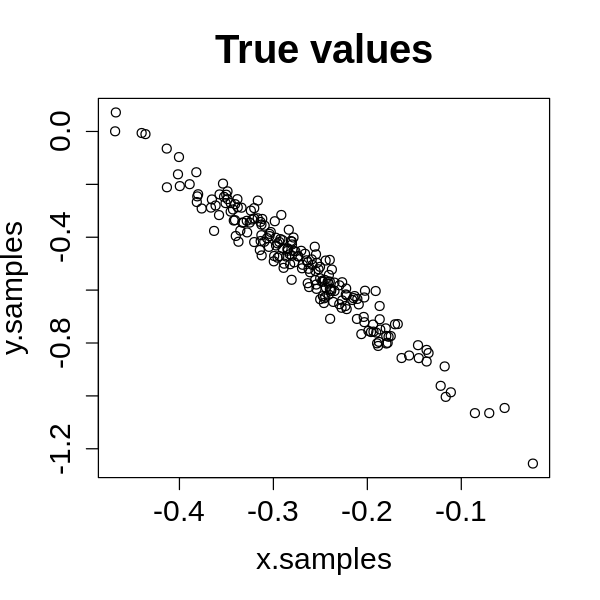

In [15]:
# Same scheme as before
N = 200
x.mu = -0.27790
x.sigma = 0.076

x.samples = rnorm(N, x.mu , x.sigma)
x.obs.errors <- rnorm(N,0,0.1) 
x.obs.errors <- abs(x.obs.errors)
x.obs.samples <- rnorm(N, x.samples, x.obs.errors)  

# Now, let us define the predicted variable
y.slope = -2.73
y.intercept = -1.24
y.sigma = 0.05
y.samples = rnorm(N, y.slope*x.samples + y.intercept , y.sigma)
y.obs.errors <- rnorm(N,0,0.1)
y.obs.errors <- abs(y.obs.errors)
y.obs.samples <- rnorm(N, y.samples, y.obs.errors) 


par(cex.axis=1.5,cex.lab=1.5)
plot(x.samples, y.samples, main="True values",cex.main=2)

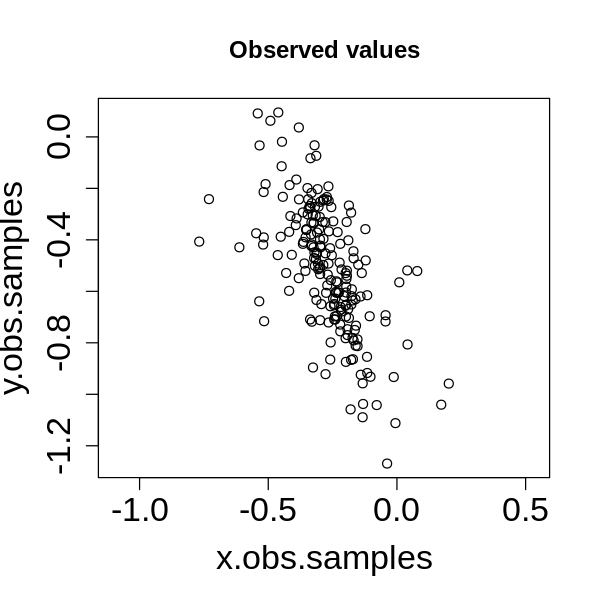

In [16]:
plot(x.obs.samples, y.obs.samples, asp = 1, cex.axis=1.7,cex.lab=1.7, main="Observed values")

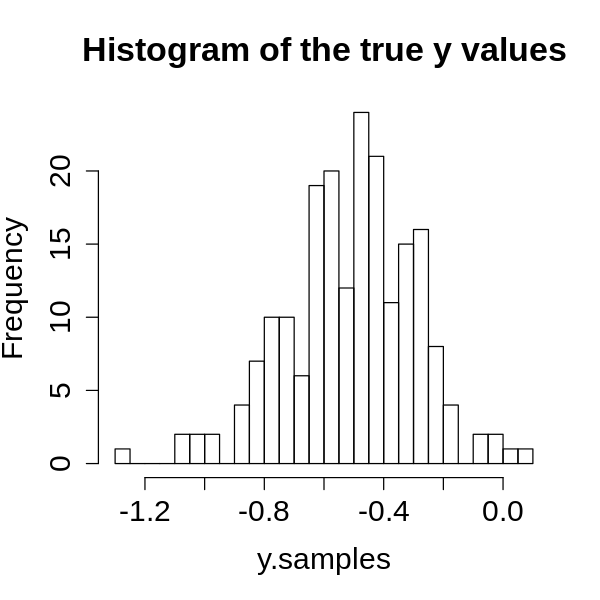

In [17]:
hist(y.samples,breaks=25,main="Histogram of the true y values", cex.lab=1.5,cex.axis=1.5,cex.main=1.7)

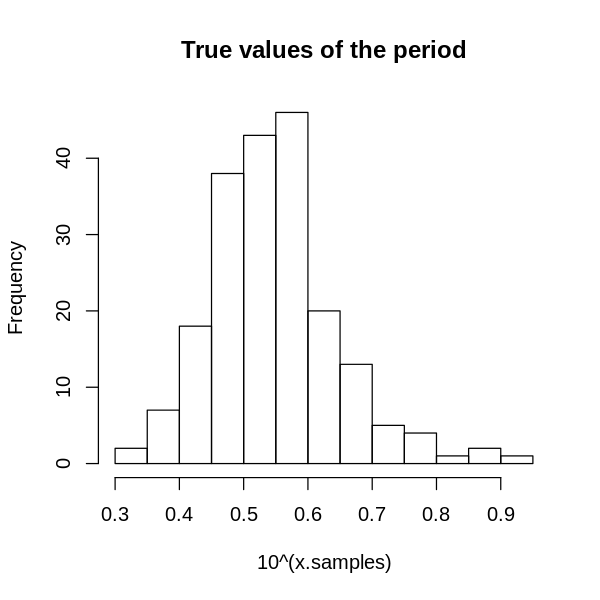

In [18]:
# Remember that the predictor variable x is akin to the logarithm of the period
hist(10^(x.samples),main="True values of the period")

In [19]:
# Show the correlation between true variables...
cor(x.samples,y.samples)

[1] -0.9736966

In [20]:
# ... and between observed variables
cor(x.obs.samples,y.obs.samples)

[1] -0.6134957

Now that we have generated the data, let us express our model in Stan terms...

In [21]:
# Create the stan model object
stanmodelcode <-'

data {                      
  int<lower=0> N;           
  vector[N] obsx;              
  vector[N] obsy;             
  vector<lower=0>[N] sigmaobsx;       
  vector<lower=0>[N] sigmaobsy;        
}

parameters {                 
  real mu;
  real alpha;               
  real beta1;
  real<lower=0> sigma;
  real<lower=0> sigmax;
  vector[N] x;               
  vector[N] y;
}

model {                    
  //priors
  alpha ~ normal(0, 10);             
  beta1 ~ normal(0, 10);
  sigma ~ uniform(0, 10);   
  sigmax ~ uniform(0, 10);
 
//likelihood
  for (n in 1:N) {
    x[n] ~ normal(mu, sigmax);
    y[n] ~ normal(alpha + beta1 * x[n], sigma);
    
    // Likelihood components

    obsx[n] ~ normal(x[n], sigmaobsx[n]);
    obsy[n] ~ normal(y[n], sigmaobsy[n]);

  }
}
'

... and sample from the posterior:

In [22]:
# Create the data list object
dat = list(N = N, obsy=y.obs.samples, obsx=x.obs.samples,sigmaobsy=y.obs.errors,sigmaobsx=x.obs.errors)


fit1 <- stan(model_code = stanmodelcode, chains = 1, data = dat, iter = 1, verbose = FALSE, ,refresh=-1)

fit2 = stan(fit=fit1 , data = dat,  iter = 5000  , warmup = 3000, chains = 3,verbose=FALSE, refresh=-1  )

# summary (commented out because this is a model with many parameters and the
# output is very long)
# print(fit2, digits_summary=4)


Gradient evaluation took 7.2e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.72 seconds.
Adjust your expectations accordingly!


         performed for num_warmup < 20


 Elapsed Time: 1e-06 seconds (Warm-up)
               0.000209 seconds (Sampling)
               0.00021 seconds (Total)



Warning message:
“There were 1 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”Warning message:
“There were 183 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

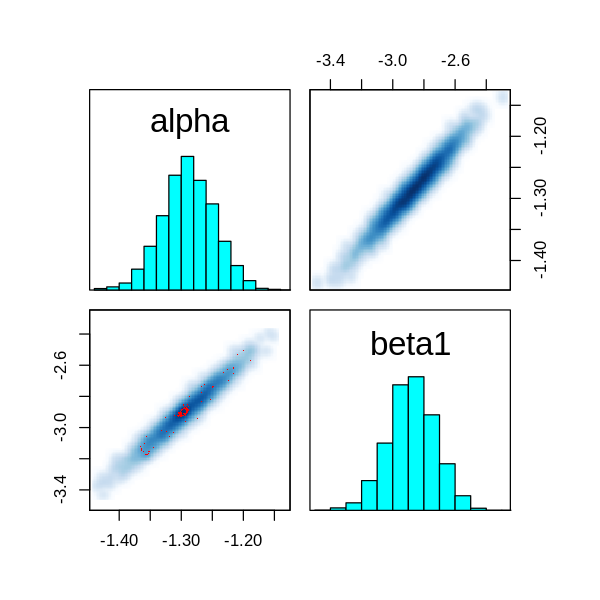

In [23]:
pairs(fit2,pars = c("alpha","beta1"))

# Bayesian models to Infer PL(Z) relations using Gaia parallaxes

In this section we construct an HBM to infer a Period-Lumninosity-Metallicity relation for RRL ab stars using Gaia parallaxes and photometry in the $K_{\rm s}$-band. 

We first import the local file `RRLyrae200Dambis.dat` into a data frame and compute some derived parameters:

In [24]:
full <- read.table("RRLyrae200Dambis.dat",header=TRUE,na.strings = "NA",
                   colClasses =c(rep("character",3),rep("numeric",6),"character",
                                 rep("numeric",2),rep("character",1),rep("numeric",11)) )


n <- nrow(full)
full$K0    <- with(full, X.Kmag. - 0.114*AV ) 
full$em    <- with(full, e_.Kmag.) # Does not include uncertainty in dereddening
full$elogP <- with(full, LogP/(LogP*100) )   
full$emet  <- with(full, 0.2*Met_Harris/(Met_Harris) )     
#attach(full)
str(full)

'data.frame':	200 obs. of  28 variables:
 $ Name          : chr  "IK_Hya" "FW_Lup" "SW_And" "CI_And" ...
 $ TYCHO_1       : chr  "6675-28-1" "7839-1841-1" "1737-1702-1" "2828-830-1" ...
 $ HIP           : chr  "58907" "75234" "1878" "8939" ...
 $ dec           : num  -27.7 -40.9 29.4 43.8 -29.7 ...
 $ dec_error     : num  0.104 0.163 0.31 0.185 0.166 ...
 $ parallax      : num  1.247 2.743 1.765 0.379 0.828 ...
 $ parallax_error: num  0.292 0.236 0.261 0.265 0.228 ...
 $ ra            : num  181.2 230.61 5.93 28.78 154.02 ...
 $ ra_error      : num  0.205 0.237 0.175 0.246 0.155 ...
 $ source_id     : chr  "3486473753028871808" "6005656893165960704" "2857456207478683776" "349612811796499584" ...
 $ G_mean        : num  10.02 8.89 9.63 12.03 10.78 ...
 $ Err_G         : num  0.0109 0.0118 0.0325 0.0298 0.0131 ...
 $ RRt_1         : chr  "AB" "AB" "AB" "AB" ...
 $ X.Vmag.       : num  10.11 9.02 9.71 12.24 10.86 ...
 $ e_.Vmag.      : num  0.018 0.012 0.009 0.018 0.006 0.012 0.005 0.007 

The data frame `full` includes, for the `n` stars in the sample, the following fields:

* The (measured) $K_{\rm s}$-band apparent magnitudes (`K0`), the decadic logarithm of periods  in days (`LogP`), parallaxes (`parallax`),  metallicities (`Met_Harris`) and extinctions (`AV`):  $\left(\hat{m}_{i},\log\hat{P}_{i},\hat{\varpi}_{i},\widehat{[\mathrm{Fe/H}]}_{i},\hat{A}_{m_{i}}\right)$

* The uncertainties of the former quantities: `em`, `elogP`, `parallax_error` and `emet`.


Now, we are going to construct the HBM. Let us present first the resulting DAG associated to the model. In the following paragraphs we detail its construction procedure.


![](graph.png)




We start modelling the stochastic linear relationship 
 
$$
M_{i}=b+c\cdot\log P_{i}+k\cdot{[\mathrm{Fe/H}]}_{i}
$$  

where $M_{i}$, $\log P_{i}$ and ${[\mathrm{Fe/H}]}_{i}$ are, respectively, the absolute magnitude, the decadic logarithm of the intrinsic period and the intrinsic metallicity of the i-th star in the sample. Note that we do not know the values of the intrinsic (true) astrophysical parameters $\log P_{i}$ and ${[\mathrm{Fe/H}]}_{i}$, but we do know their measured values $\log\hat{P}_{i}$ and $\widehat{[\mathrm{Fe/H}]}_{i}$ and associated uncertainties. To incorporate second order effects like the evolutionary status of the star in the PLZ relation, we include an intrinsic width $w$. The main objective of the model is then to infer the parameters $b$, $c$, $k$ and $w$, where $c=\tan\left(\phi_{1}\right)$ and $k=\tan\left(\phi_{2}\right)$.

Now, we need to relate absolute magnitudes to apparent magnitudes using the deterministic relation
$$
m_{i}=M_{i}-5\log\varpi_{i}+10+A_{m_{i}}
$$
where $m_{i}$ is the true (extincted) apparent magnitude and $\varpi_{i}$ is the true parallax measured in mas. Note, again, that we do not know the values of the true extincted apparent magnitudes and parallaxes but we do know their measured values $\hat{m}_{i}$, $\hat{\varpi}_{i}$ and uncertainties.


At this point we put into the DAG associated to our HBM, a rectangle that replicates with the $n$ stars in the sample and include in it the nodes corresponding to extinctions $A_{m_{i}}$ and true astrophysical parameters $m_{i}$, $M_{i}$, $\log P_{i}$ and $Z_{i}$ , and the arcs between these nodes, which are given by the two relations above. For example, we draw solid (stochastic) arcs from $M_{i}$ to $\log P_{i}$ and ${[\mathrm{Fe/H}]}_{i}$ and dashed (deterministic) arcs from $m_{i}$ to $M_{i}$ and $\varpi_{i}$. Outside the rectangle, we include the parameters $b$, $\phi_1$, $\phi_2$ and $w$ of the PLZ relation and trace the arcs from $M_{i}$ to those nodes. We also set the distribution of the i-th absolute magnitude to a Gaussian of mean $b+c\log P_{i}+k{[\mathrm{Fe/H}]}_{i}$ and standard deviation $w$.

We continue the construction of the model and the DAG linking the measured astrophysical parameters to the true ones. So, we include $\hat{m}_{i}$, $\log\hat{P}_{i}$, $\hat{\varpi}_{i}$ and $\widehat{[\mathrm{Fe/H}]}_{i}$ inside the  rectangle of the DAG and trace the corresponding solid (stochastic) arcs to the true parameters. To each measured astrophysical parameter we assign a Gaussian distribution with its mean equal to the value of the true parameter and its standard deviation equal to the uncertainty provided in our data set. For example, for the measured apparent magnitude we declare $\hat{m}_{i}\sim\mathsf{N}\left(m_{i},\sigma_{m_{i}}\right)$.  

Next, we assign prior probability distributions to the true astrophysical parameters $\log P_{i}$, ${[\mathrm{Fe/H}]}_{i}$ and $\varpi_{i}$ and trace the DAG arcs from these astrophysical parameters to the parameters of the distributions assigned to them. We set $\log P_{i}\sim\mathsf{N}\left(\mu_{P},\sigma_{P}\right)$, $\left[\mathrm{Fe/H}\right]_{i}\sim\mathsf{N}\left(\mu_{Z},\sigma_{Z}\right)$ and $\varpi_{i}\sim\mathsf{logN}\left(\beta,\gamma\right)$. For the location $\mu$ and scale $\sigma$ hyperparameters of the $\log P_{i}$ and ${[\mathrm{Fe/H}]}_{i}$ distributions we assign $\mathsf{N}\left(0,10\right)$ and $\mathsf{Exp}\left(0.1\right)$ hyperpriors, respectively.  For the hyperparameters $\beta$ and $\gamma$ of the $\varpi_{i}$ distribution  we assign the hyperpriors $\beta\sim\mathsf{N}\left(\mu_{\beta}=0,\sigma_{\beta}=2\right)$ and $\gamma\sim\mathsf{Exp}\left(1\right)$. In the DAG there is an aditional arc from the node $\varpi_{i}$ to the node-hyperparameter $\alpha$. This last node represents the skewness parameter of a skew log-Normal distribution of which the $\mathsf{logN}\left(\beta,\gamma\right)$ prior is a particular case when $\alpha=0$.    

To finish the BGM construction, we assign the following prior distributions to the parameters of the PLZ relation:  $b\sim\mathsf{N}\left(\mu_{\beta}=0,\sigma_{\beta}=10\right)$ to the intercept,   $\phi_{1}\sim\mathsf{U}\left(-3.14/2,0\right)$  and $\phi_{2}\sim\mathsf{U}\left(-3.14/6,3.14/6\right)$ to the slope angles, and $w\sim\mathsf{Exp}\left(\lambda_{w}=1\right)$ to the spread. 


We define now the Stan model for our problem. The code allows us to select between several alterative parallax priors as we will see below:

In [25]:
stanPLZcode <-'
functions{

  /**
   * Returns the log probability of a skew log-Normal 
   * probability density distribution
   *
   * References 
   *
   * @param x
   * @param beta       
   * @param gamma       
   * @param shape       
   *
   * return Log probability
  */
  real skew_lognormal_lpdf(vector x, real beta, real gamma, real shape) {
    vector[num_elements(x)] prob;
    real lprob;
    lprob = sum( - log(x)) + skew_normal_lpdf(log(x) | beta, gamma, shape);
    return lprob;
  }

/**
   * Returns log probability of exponentially decresing volume 
   * density (EDVD) prior 
   *
   * References
   * Bailer-Jones, C. A. L. 2015, Publications of the Astronomical
   * Society of the Pacific, 127, 994
   *
   * @param x     Parallax measured in mas
   * @param L     Scale length 
   * @param k     offset
   *
   * return Log probability
  */
  real expvol_lpdf(vector x, real L, real k) {
    vector[num_elements(x)] prob;
    real lprob;
    for(i in 1:num_elements(x)) {
      prob[i] = (1/(L^3*(x[i]-k)^4))*exp(-1/((x[i]-k)*L));
    }
    lprob = sum(log(prob));
    return lprob;
  }
  
}

data {
  
  // Prior selection
  int<lower=0, upper=1> is_LN;
  int<lower=0, upper=1> is_SLN;
  int<lower=0, upper=1> is_EDVD; 
  
  //  Fixed hyper-parameters 
  real betaSd[is_LN];                 // beta ~ normal(0,betaSd) 
  real gammaInvScale[is_LN];          // gamma ~ exponential(gammaInvScale) 
  real shapeSd[is_SLN];               // beta ~ normal(0,betaSd) 
  real<lower=0> LinvScale[is_EDVD];
  
  
  real widthInvScale;  // Inverse scale of intrinsic width prior
  real angleLoBound;     // Bound for PLZ log(P) term angle prior
  real angleUpBound;     // Bound for PLZ log(P) term angle prior
  real cBound;         // Bound for PLZ metallicity term angle prior  
  real bSd;            // Standar deviation of PLZ intercept term prior   
  real meanLogP0sd;    // Standard deviation of true log(P) mean prior 
  real meanZ0sd;       // Standard deviation of true metallicity mean prior 
  real<lower=0> sigmaLogP0invScale; // Inverse scale of true log(P) sd prior 
  real<lower=0> sigmaZ0invScale;    // Inverse scale of true metallicity sd prior
  real AK0Mean;        // Mean of true extinction prior  
  real AK0Sd;          // Standar deviation of true extinction prior 


 // Observations 
  int<lower=1> N;      // Number of observations
  real pi[N];          // Observed parallax
  real m[N];           // Observed apparent magnitude (reddened)
  real logP[N];        // Decadic logarithm of observed period 
  real met[N];         // Observed metallicity 
  real<lower=0> AK[N]; // Extincion in the K-band
  real epi[N];         // Uncertainty of observed parallax
  real em[N];          // Uncertainty of observed (reddened) apparent magnitude 
  real elogP[N];       // Uncertainty of logarithm of observed period 
  real emet[N];        // Uncertainty of observed metallicity 
}

parameters {
  vector<lower=0>[N] pi0;     // True parallax   
  vector[N] logP0;            // Decadic logarithm of true period 
  vector[N] met0;             // True metallicity 
  vector<lower=0>[N] AK0;     // True extinction in the K-band 
  vector[N] M;                // True absolute magnitude in the K-band 
  real meanLogP0;
  real<lower=0> sigmaLogP0;
  real meanMet0;
  real<lower=0> sigmaMet0;
  real angle;                 // PLZ log(P) term angle
  real b;                     // PLZ intercept
  real c;                     // PLZ metallicity angle
  real<lower=0> width;
  
  
  // Declare parallax prior
  real beta[is_LN];          // Size 1 if LN, 0 othewise
  real<lower=0> gamma[is_LN];
  real<lower=0> shape[is_SLN];
  real<lower=0> L[is_EDVD];   // Length scale of EDVD prior
  
  
}

model {

  real a;
  real d;
  
  // Common hyper-parameters
  meanLogP0 ~ normal(0,meanLogP0sd); 
  sigmaLogP0 ~ exponential(sigmaLogP0invScale); 
  meanMet0 ~ normal(0,meanZ0sd); 
  sigmaMet0 ~ exponential(sigmaZ0invScale);
  width ~ exponential(widthInvScale);
   #eAK ~ normal(0,eAKSd); # RELATIVE error in K-band extinction
  angle ~ uniform(angleLoBound,angleUpBound);
  b ~ normal(0,bSd);
  c ~ uniform(-cBound,+cBound);
  a = tan(angle);
  d = tan(c);
  
  
  /*** LN prior block ***/
 if (is_LN && !is_SLN) {
    // SLN hyper-parameters
    beta ~ normal(0,betaSd); 
    gamma ~ exponential(gammaInvScale);
    
 
    // True parameters
    pi0 ~ skew_lognormal(beta[1],gamma[1],0);
   

  }
    
  
  /*** SLN prior block ***/
  if (is_LN && is_SLN) {
    // SLN hyper-parameters
    beta ~ normal(0,betaSd);  
    gamma ~ exponential(gammaInvScale);
    shape ~ normal(0,shapeSd); 
    
    
    // True parameters
    pi0 ~ skew_lognormal(beta[1],gamma[1],shape[1]);

  }
     
    
  
  /*** EDVD prior block ***/
  if (is_EDVD) { 

    // EDVD hyper-parameters
    L ~ exponential(LinvScale);
    
    
      // True parameters
      pi0 ~ expvol(L[1],0); // L is size 1 if EDVD


  }

      // True parameters
      logP0 ~ normal(meanLogP0,sigmaLogP0);
      met0 ~ normal(meanMet0,sigmaMet0);
      M ~ normal(a*logP0 + d*met0 + b , width);
      AK0 ~ lognormal(AK0Mean,AK0Sd);   
  
      // likelihood
      AK ~ normal(AK0, AK0/10);
      m ~ normal(M - 5.0*log10(pi0) + 10.0 + AK0, em);  
      pi ~ normal(pi0, epi);
      logP ~ normal(logP0,elogP);
      met ~ normal(met0,emet);
    

}
'

We load the training set into a list, initialize Markov chains to random values, call the sampler, store the fit and extract posterior samples. In the present test we use a log_Normal parallax prior just as we did in the HM proposed in [Gaia Collaboration et al. (2017)](https://arxiv.org/abs/1705.00688):

In [26]:
# Create data list object

train.set <- full 



linear_data <- list(N=nrow(train.set), is_LN = 1, is_SLN = 0, is_EDVD = 0,
                    betaSd = array(10), gammaInvScale = array(0.01), 
                    shapeSd=numeric(0), LinvScale=numeric(0), 
                    widthInvScale = 1 , angleUpBound = 0, angleLoBound = -3.1416/2.0, 
                    cBound = 3.1416/6.0, bSd = 3.0, AK0Mean = -4,  AK0Sd = 3, meanLogP0sd=10  ,
                    sigmaLogP0invScale=0.1, meanZ0sd=10, sigmaZ0invScale=0.1, 
                    pi=train.set$parallax, epi=train.set$parallax_error,
                    m=train.set$X.Kmag., em=train.set$em,
                    logP=train.set$LogP, elogP=train.set$elogP,
                    met=train.set$Met_Harris, emet=train.set$emet,
                    AK=0.114*train.set$AV
                   )


n <- nrow(train.set)


initf2 <- function(chain_id = 1) {
  set.seed(chain_id)

# Create empty variables
  initpi <-  initlogp <- initmet <-  initM <- initAK <- rep(NA,n)
  
# Initialize parameters
  angle <- runif(1,-3.1416/2,0)
  m <- tan(angle)
  b <- rnorm(1,-1.0,0.3)
  c <- runif(1,-3.1416/6, 3.1416/6)
  d <- tan(c)
  #width <- rexp(1,100.0)
  width <- rexp(1,10.0)
  beta <- rnorm(1,0.0,2.0)
  gamma <- rexp(1,1.0)
  shape <- abs(rnorm(1,0,0.2))  
  L <- abs(rnorm(1,0.5,0.5))
  eAK <- rexp(1,1.0)
  
  initMeanlogP <- -0.2
  initSigmalogP <- 0.1
  initMeanMet <- -1.3
  initSigmaMet <- 0.5
  
  
  initlogp <- rnorm(n,full$LogP,0.01)
  initmet <- rnorm(n,full$Met_Harris,0.5)
  initM <- rnorm(n, m*full$LogP + d*full$Met_Harris + b, width)
  initpi <-  10^((initM - full$K0 + 10.0)/5.0) # Initialize almost at random (m,b,d can take almost any value)
  initAK <- abs(rnorm(n, 0.114*train.set$AV, 0.5)) 
   
  list(logP0=initlogp,  met0 = initmet,  
                 pi0=initpi, M=initM, AK0=initAK, meanMet0=initMeanMet,
              sigmaMet0=initSigmaMet, 
                meanLogP0=initMeanlogP,  sigmaLogP0=initSigmalogP, angle=angle  ,
              b=b, c=c, width=width, eAK=eAK ,beta=array(beta) , gamma=array(gamma) )
     
} 

# generate a list of lists to specify initial values
n_chains <- 4
init_ll <- lapply(1:n_chains, function(id) initf2(chain_id = id))

nsamples_chain =5000 
nsamples <- n_chains*nsamples_chain/2

fit <- stan(model_code = stanPLZcode, data = linear_data, iter = nsamples_chain, 
            chains = n_chains,init=init_ll,control= list(adapt_delta = 0.8), verbose = FALSE,init_r=2)


Warning message:
“There were 801 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 2430 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Finally, we plot the marginal posterior distributions from the MCMC samples.The diagonal shows the uni-dimensional marginal distributions for the intrinsic width of the relationship, the angle of the metallicity term in the linear relation, the intercept and the angle of the log(P) term.

Inference for Stan model: 49a6cb841923f1c2e1dea75017c1cf2e.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean     sd    2.5%     25%     50%     75%   97.5% n_eff
width       0.1326  0.0208 0.0650  0.0149  0.0886  0.1333  0.1780  0.2589    10
c           0.0711  0.0047 0.0992 -0.1241  0.0057  0.0726  0.1371  0.2627   446
b          -0.6755  0.0138 0.2527 -1.2100 -0.8385 -0.6646 -0.4948 -0.2168   334
angle      -0.7655  0.0135 0.2675 -1.1508 -0.9739 -0.8161 -0.5965 -0.1474   395
beta[1]    -0.3178  0.0022 0.0389 -0.3939 -0.3440 -0.3172 -0.2915 -0.2416   309
gamma[1]    0.4333  0.0002 0.0225  0.3914  0.4179  0.4325  0.4479  0.4793 10000
meanLogP0  -0.2779  0.0001 0.0054 -0.2885 -0.2815 -0.2779 -0.2743 -0.2671 10000
sigmaLogP0  0.0756  0.0000 0.0040  0.0681  0.0729  0.0755  0.0783  0.0836 10000
meanMet0   -1.3156  0.0004 0.0357 -1.3841 -1.3400 -1.3155 -1.2916 -1.2464 10000
sigmaMet0   0.4633  0

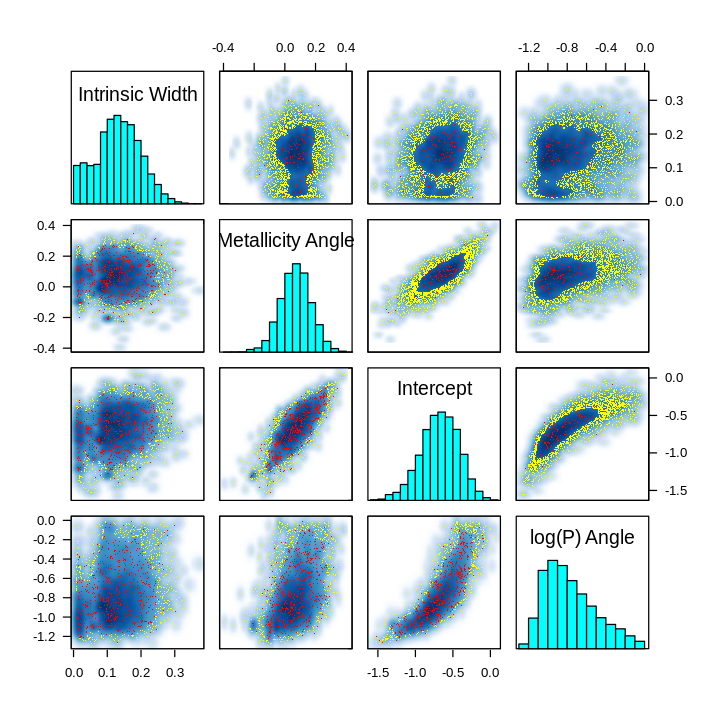

In [27]:
options(repr.plot.width=6, repr.plot.height=6)

print(fit, pars=c("width","c", "b","angle","beta","gamma","shape","meanLogP0",
                    "sigmaLogP0","meanMet0","sigmaMet0"),digits_summary=4)  
 
pairs(fit, pars = c("width", "c", "b","angle"), labels=c("Intrinsic Width", "Metallicity Angle", "Intercept","log(P) Angle"), 
      log = FALSE, las = 1)

## Playing with different hyperpriors, priors and constants

It is surprising that the maximum a posteriori value of the log(P) slope according to the MCMC samples is smaller than -1.0. A value of $\tan(\phi_1)=-1$ corresponds to a slope of $-0.785$ (units omitted). The upper boundary of the support of the marginal posterior is $\approx -1.2$ which corresponds to a slope of -0.88. These are all values that are far from the well established values from the literature. For example, [Muraveva et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...807..127M) give a value of -2.73 for the period coefficient of PLZ relation in the same photometric band and stars in the bar of the Large Magellanic Cloud. No parallax measurement is involved in that work and hence, the scatter in the values used is not due the imprecise parallax measurement but only to the intrinsic dispersion of distances in the bar (and other concomitant factors). So, there must be something wrong in our result and the remainder of this tutorial is devoted to the quest for the culprit of the seemingly poor results.

### Is the wrong choice of hyperprior the culprit for the poor results?

Choosing a lognormal prior was a risky choice. It has not been used before in this context and it seems natural to be suspicious of it. The choice was inspired by the fact that it is zero for negative values, has a long tail for large positive values, and it resembles the distribution of measured parallaxes. Of course, this can be misleading given the large measurement uncertainties in the sample.

So, let us first try with a far more popular prior: the exponentially decaying space density (EDSD) prior defined in [Bailer-Jones (2015)](http://adsabs.harvard.edu/abs/2015PASP..127..994B). 

Warning message:
“There were 850 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 16 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Inference for Stan model: 49a6cb841923f1c2e1dea75017c1cf2e.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean     sd    2.5%     25%     50%     75%   97.5% n_eff
width       0.1392  0.0044 0.0474  0.0583  0.1035  0.1365  0.1716  0.2372   116
c           0.1082  0.0042 0.1018 -0.0937  0.0401  0.1099  0.1795  0.3031   592
b          -0.7000  0.0103 0.2610 -1.2361 -0.8758 -0.6912 -0.5207 -0.2026   646
angle      -0.8489  0.0090 0.2499 -1.1908 -1.0341 -0.9040 -0.7088 -0.2267   766
L[1]        0.5052  0.0006 0.0240  0.4603  0.4887  0.5045  0.5215  0.5532  1704
meanLogP0  -0.2778  0.0001 0.0053 -0.2882 -0.2814 -0.2779 -0.2743 -0.2674 10000
sigmaLogP0  0.0756  0.0000 0.0039  0.0683  0.0729  0.0754  0.0781  0.0836 10000
meanMet0   -1.3161  0.0004 0.0359 -1.3872 -1.3404 -1.3155 -1.2922 -1.2456 10000
sigmaMet0   0.4635  0.0003 0.0277  0.4115  0.4443  0.4625  0.4823  0.5199 10000
             Rhat
wid

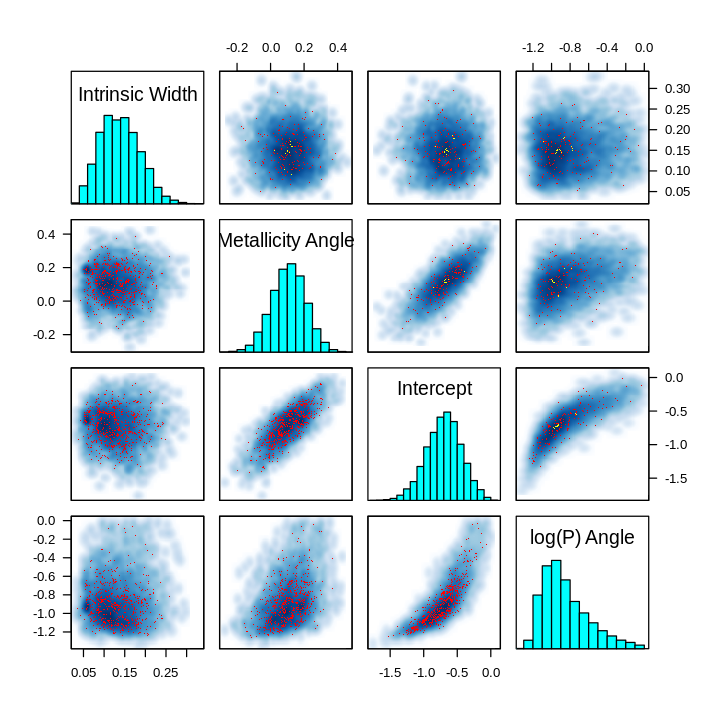

In [28]:
train.set <- full 

linear_data <- list(N=nrow(train.set), is_LN = 0, is_SLN = 0, is_EDVD = 1,
                    betaSd = numeric(0), gammaInvScale = numeric(0), 
                    shapeSd=numeric(0), LinvScale=array(0.5), 
                    widthInvScale = 0.1 , angleUpBound = 0, angleLoBound = -3.1416/2.0, 
                    cBound = 3.1416/6.0, bSd = 3.0, AK0Mean = -4,  AK0Sd = 3, meanLogP0sd=10  ,
                    sigmaLogP0invScale=0.1, meanZ0sd=10, sigmaZ0invScale=0.1, 
                    pi=train.set$parallax, epi=train.set$parallax_error,
                    m=train.set$X.Kmag., em=train.set$em,
                    logP=train.set$LogP, elogP=train.set$elogP,
                    met=train.set$Met_Harris, emet=train.set$emet,
                    AK=0.114*train.set$AV
                   )

n <- nrow(train.set)

initf2 <- function(chain_id = 1) {
  set.seed(chain_id)

# Create empty variables
  initpi <-  initlogp <- initmet <-  initM <- initAK <- rep(NA,n)
   
  
# Initialize parameters
  angle = runif(1,-3.1416/2,0)
  m = tan(angle)
  b=rnorm(1,-1.0,0.3)
  c = runif(1,-3.1416/6, 3.1416/6)
  d = tan(c)
  width=rexp(1,10.0)
  L = abs(rnorm(1,0.5,0.5))
  eAK=rexp(1,1.0)
  
  initMeanlogP = -0.2
  initSigmalogP = 0.1
  initMeanMet= -1.3
  initSigmaMet = 0.5
  

  initlogp = rnorm(n,full$LogP,0.01)
  initmet = rnorm(n,full$Met_Harris,0.5)
  initM = rnorm(n, m*full$LogP + d*full$Met_Harris + b, width)
  initpi =  10^((initM- full$K0 +10.0)/5.0) # Initialize almost at random (m,b,d can take almost any value)
  initAK = abs(rnorm(n, 0.114*train.set$AV, 0.5)) 
    

  list(logP0=initlogp,  met0 = initmet,  
                 pi0=initpi, M=initM, AK0=initAK, meanMet0=initMeanMet,
              sigmaMet0=initSigmaMet, 
                meanLogP0=initMeanlogP,  sigmaLogP0=initSigmalogP, angle=angle  ,
              b=b, c=c, width=width, eAK=eAK ,L=array(L)  )
     
} 

# generate a list of lists to specify initial values
n_chains <- 4
init_ll <- lapply(1:n_chains, function(id) initf2(chain_id = id))

nsamples_chain =5000 
nsamples <- n_chains*nsamples_chain/2

fit <- stan(model_code = stanPLZcode, data = linear_data, iter = nsamples_chain, 
            chains = n_chains,init=init_ll,control= list(adapt_delta = 0.8), verbose = FALSE,init_r=2,refresh=-1)

print(fit, pars=c("width","c", "b","angle","L","meanLogP0",
                    "sigmaLogP0","meanMet0","sigmaMet0"),digits_summary=4)


pairs(fit, pars = c("width", "c", "b","angle"), labels=c("Intrinsic Width", "Metallicity Angle", "Intercept","log(P) Angle"), 
      log = FALSE, las = 1)

 


Mmmmm. This does not seem to solve the problem that we are seriously underestimating the slope. Let us try with a variation of the lognormal prior for parallaxes: the skewed lognormal distribution:

Warning message:
“There were 2738 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”Warning message:
“There were 7 transitions after warmup that exceeded the maximum treedepth. Increase max_treedepth above 10. See
http://mc-stan.org/misc/warnings.html#maximum-treedepth-exceeded”Warning message:
“There were 4 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”Warning message:
“Examine the pairs() plot to diagnose sampling problems
”

Inference for Stan model: 49a6cb841923f1c2e1dea75017c1cf2e.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

              mean se_mean     sd    2.5%     25%     50%     75%   97.5% n_eff
width       0.1785  0.0060 0.0600  0.0770  0.1338  0.1762  0.2185  0.3040   100
c           0.0784  0.0040 0.0962 -0.1086  0.0121  0.0770  0.1433  0.2628   578
b          -0.5988  0.0101 0.2303 -1.0580 -0.7544 -0.5813 -0.4408 -0.1754   521
angle      -0.6485  0.0118 0.2763 -1.0854 -0.8632 -0.6833 -0.4522 -0.0730   553
beta[1]    -0.8114  0.0016 0.0513 -0.9067 -0.8458 -0.8135 -0.7792 -0.7060  1068
gamma[1]    0.6571  0.0013 0.0488  0.5689  0.6229  0.6553  0.6890  0.7550  1462
shape[1]    3.4321  0.0443 1.1717  1.9616  2.7571  3.2580  3.8540  5.8980   700
meanLogP0  -0.2779  0.0001 0.0055 -0.2886 -0.2816 -0.2780 -0.2743 -0.2670 10000
sigmaLogP0  0.0757  0.0000 0.0040  0.0686  0.0729  0.0754  0.0783  0.0842 10000
meanMet0   -1.3162  0

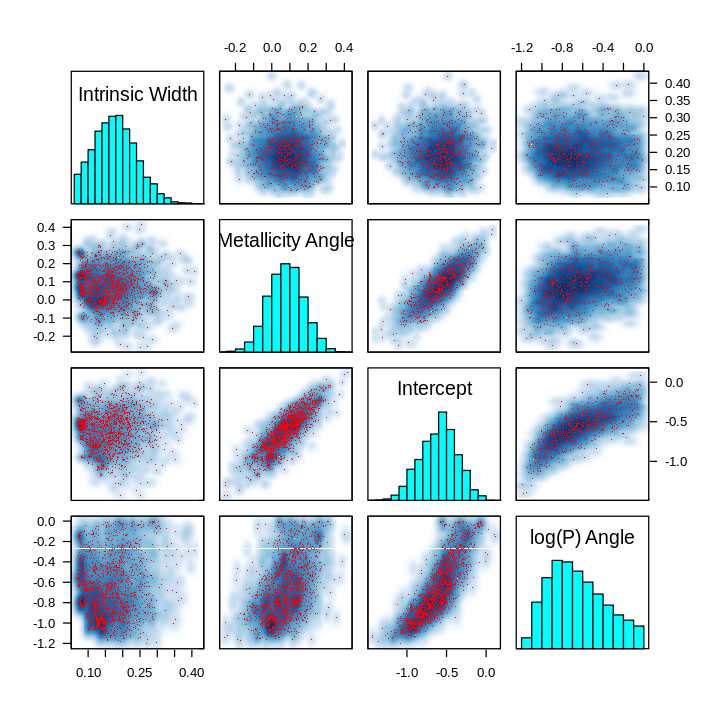

In [29]:
train.set <- full 

linear_data <- list(N=nrow(train.set), is_LN = 1, is_SLN = 1, is_EDVD = 0,
                    betaSd = array(10), gammaInvScale = array(0.01), 
                    shapeSd=array(10), LinvScale=numeric(0), 
                    widthInvScale = 0.1 , angleUpBound = 0, angleLoBound = -3.1416/2.0, 
                    cBound = 3.1416/6.0, bSd = 3.0, AK0Mean = -4,  AK0Sd = 3, meanLogP0sd=10  ,
                    sigmaLogP0invScale=0.1, meanZ0sd=10, sigmaZ0invScale=0.1, 
                    pi=train.set$parallax, epi=train.set$parallax_error,
                    m=train.set$X.Kmag., em=train.set$em,
                    logP=train.set$LogP, elogP=train.set$elogP,
                    met=train.set$Met_Harris, emet=train.set$emet,
                    AK=0.114*train.set$AV
                   )

n <- nrow(train.set)


initf2 <- function(chain_id = 1) {
  set.seed(chain_id)

# Create empty variables
  initpi <-  initlogp <- initmet <-  initM <- initAK <- rep(NA,n)
  
# Initialize parameters
  angle <- runif(1,-3.1416/2,0)
  m <- tan(angle)
  b <- rnorm(1,-1.0,0.3)
  c <- runif(1,-3.1416/6, 3.1416/6)
  d <- tan(c)
  

  width <- rexp(1, 10.0)
  beta <- rnorm(1, 0.0, 2.0)
  gamma <- rexp(1, 1.0)
  shape <- abs(rnorm(1, 0, 0.2))  
  eAK <- rexp(1,1.0)
  
  initMeanlogP <- -0.2
  initSigmalogP <- 0.1
  initMeanMet <- -1.3
  initSigmaMet <- 0.5
  
  
  initlogp <- rnorm(n, full$LogP,0.01)
  initmet <- rnorm(n, full$Met_Harris,0.5)
  initM <- rnorm(n, m*full$LogP + d*full$Met_Harris + b, width)
  initpi <-  10^((initM - full$K0 + 10.0)/5.0) # Initialize almost at random (m,b,d can take almost any value)
  initAK <- abs(rnorm(n, 0.114*train.set$AV, 0.5)) 
    

  list(logP0=initlogp,  met0 = initmet,  
                 pi0=initpi, M=initM, AK0=initAK, meanMet0=initMeanMet,
              sigmaMet0=initSigmaMet, 
                meanLogP0=initMeanlogP,  sigmaLogP0=initSigmalogP, angle=angle  ,
              b=b, c=c, width=width, eAK=eAK ,beta=array(beta) , gamma=array(gamma), shape=array(shape) )
     
} 

# generate a list of lists to specify initial values
n_chains <- 4
init_ll <- lapply(1:n_chains, function(id) initf2(chain_id = id))

nsamples_chain =5000 
nsamples <- n_chains*nsamples_chain/2

fit <- stan(model_code = stanPLZcode, data = linear_data, iter = nsamples_chain, 
            chains = n_chains,init=init_ll,control= list(adapt_delta = 0.8), verbose = FALSE,init_r=2,refresh=-1)


 print(fit, pars=c("width","c", "b","angle","beta","gamma","shape","meanLogP0",
                    "sigmaLogP0","meanMet0","sigmaMet0"),digits_summary=4)


pairs(fit, pars = c("width", "c", "b","angle"), labels=c("Intrinsic Width", "Metallicity Angle", "Intercept","log(P) Angle"), 
      log = FALSE, las = 1)

Well, it gets better but not enough. If you try with other (also reasonable) values of the hyperparameters of each of the three models considered (or even as we did, with a mixture of Gaussians for the distribution of true parallaxes), you will find that there is no way to obtain values in consonance with the literature values. It is at this point that we begin to suspect that there may be a hidden (non-evident) bias in our data or an equally hidden effect that we have not included in our model. 

A good way to check for biases would be to generate a simulated sample of measurements with the same characteristics as our data set except that the absolute magnitudes are assigned using the PLZ relation by Muraveva et al. (2015). From these absolute magnitudes and the measured apparent magnitudes we can generate a parallax. We omit all the details and the distinction between true and measured values in order to keep the tutorial simple, but these (details) can be found in [Delgado et al (2018)](https://arxiv.org/abs/1803.01162). The result of these simulations is the same: even if we generated data with a slope of -2.73 the inferred slope is systematically underestimated. Our conclusion (justified in the reference above) is that this is the result of an additional correlation between parallaxes, periods and metallicities that is not included in the model. This correlation is a direct consequence of spatial metallicity differences in the Milky Way and the correlation between periods and metallicities. "But that is another story and shall be told another time..." ;)